# Analysis by Michał Heit EAD PROJECT

In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

Load data and drop column 'Unnamed: 0' which is only indexing.
We can drop Epoch types because when we have dates, hours in normal readable type.
NOTE: WEATHER DATA FROM DAYTON IS PER DAY

In [307]:
dayton_df = pd.read_csv('./datasets/dayton.csv')

epoch_columns = ['Unnamed: 0', 'datetimeEpoch', 'sunriseEpoch', 'sunsetEpoch']
dayton_df.drop(epoch_columns, axis=1, inplace=True)

dayton_df['datetime'] = pd.to_datetime(dayton_df['datetime'])
dayton_df.set_index('datetime', inplace=True)

Load electrical consumption from dayton
NOTE: ELECTRICAL CONSUMPTION IS PER HOUR

In [308]:
electrical_cons_dayton_df = pd.read_csv('./datasets/Energy_consumption_Dayton.csv')
electrical_cons_dayton_df['Datetime'] = pd.to_datetime(electrical_cons_dayton_df['Datetime'])
electrical_cons_dayton_df = electrical_cons_dayton_df.sort_values(['Datetime'])

original_e_cons_df = electrical_cons_dayton_df.copy() # full energy consumption df


Make electrical consumption per day by using groupby and do it with function mean

In [309]:
electrical_cons_dayton_df = electrical_cons_dayton_df.set_index('Datetime').groupby(pd.Grouper(freq='d')).sum()

Let's concatenate electrical and weather df for analyzing

In [310]:
complete_df = pd.concat([electrical_cons_dayton_df, dayton_df], axis=1, join='inner')

First look on dataset, I can see a lot of NaNs in some columns

In [311]:
complete_df = complete_df['2005':]

let's check the percent of nans in columns

In [312]:
missing_columns = complete_df.isnull().sum() / len(complete_df.index) * 100

Missing columns:
* precipprob
* preciptype
* snow
* snowdepth
* windgust
* winddir
* solarradation
* solarenergy
* tzoffset

All of them are mostly empty expect winddir but I don't really think it has some influence on energy. Let's drop these variables.

In [313]:
missing_columns = missing_columns[(missing_columns > 0)]

In [314]:
missing_columns

precipprob        100.000000
preciptype        100.000000
snow               78.259117
snowdepth          70.723353
windgust           45.738465
winddir            14.688696
solarradiation     98.488817
solarenergy        98.488817
tzoffset           49.224260
dtype: float64

In [315]:
complete_df.drop(list(missing_columns.index), inplace=True, axis=1)

I decide to drop description too because we have almost the same information from icon column and it's better to categorize.
To be honest source and stations don't see to give some value to model.

In [316]:
complete_df.drop(['description', 'stations', 'source', 'conditions'], inplace=True, axis=1)

Distribution of variable that I want to predict, We can see a periodic trend. Probably the energy depends on seasons.

<AxesSubplot:xlabel='Lata', ylabel='Energia[MWd]'>

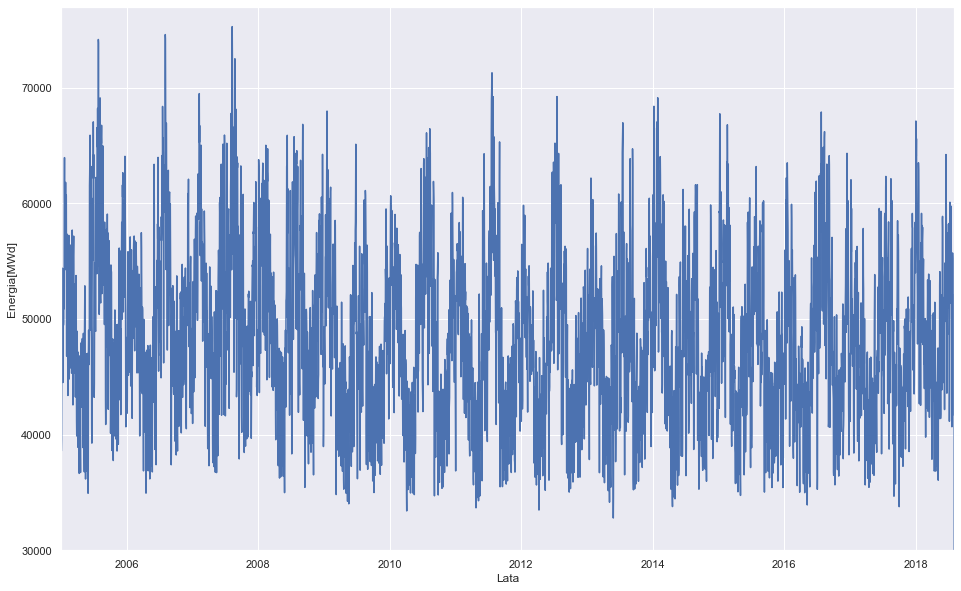

In [317]:
complete_df['Energy_MW'].plot(xlabel='Lata', ylabel='Energia[MWd]', figsize=(16, 10), grid=True, ylim=(30000, 77000))

In [318]:
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5:'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

complete_df['year'] = complete_df.index.year
complete_df['quarter'] = complete_df.index.quarter
complete_df['month'] = complete_df.index.month
complete_df['week'] = complete_df.index.week
complete_df['day'] = complete_df.index.day
complete_df['week_day'] = complete_df.index.weekday
complete_df['season'] = complete_df['month'].replace(seasons)


C:\Users\micha\AppData\Local\Temp\ipykernel_7232\4269463895.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  complete_df['week'] = complete_df.index.week


# 1. PERIODICAL ANALYSIS

# 1.1 Decomposition

<AxesSubplot:title={'center':'Energy rolled avg365'}, xlabel='Years', ylabel='Energy[MWd]'>

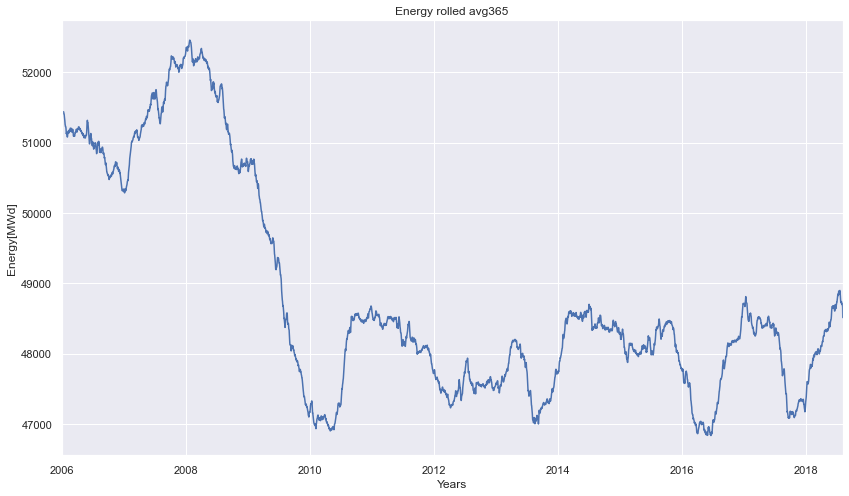

In [319]:
complete_df['Energy_MW'].rolling(365).mean()['2006':].plot(xlabel='Years', ylabel='Energy[MWd]', figsize=(14, 8), grid=True, title='Energy rolled avg365')

<AxesSubplot:title={'center':'Energy rolled avg90 (seasons)'}, xlabel='Months', ylabel='Energy[MWd]'>

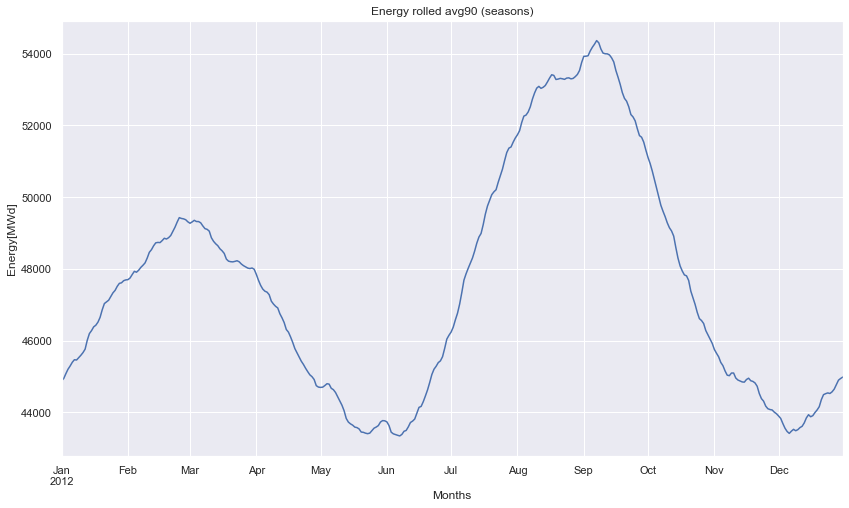

In [320]:
complete_df['Energy_MW']['2011':'2013'].rolling(90).mean()['2012':'2012'].plot(xlabel='Months', ylabel='Energy[MWd]', figsize=(14, 8), grid=True, title='Energy rolled avg90 (seasons)')

<AxesSubplot:title={'center':'Energy rolled avg30'}, xlabel='Months', ylabel='Energy[MWd]'>

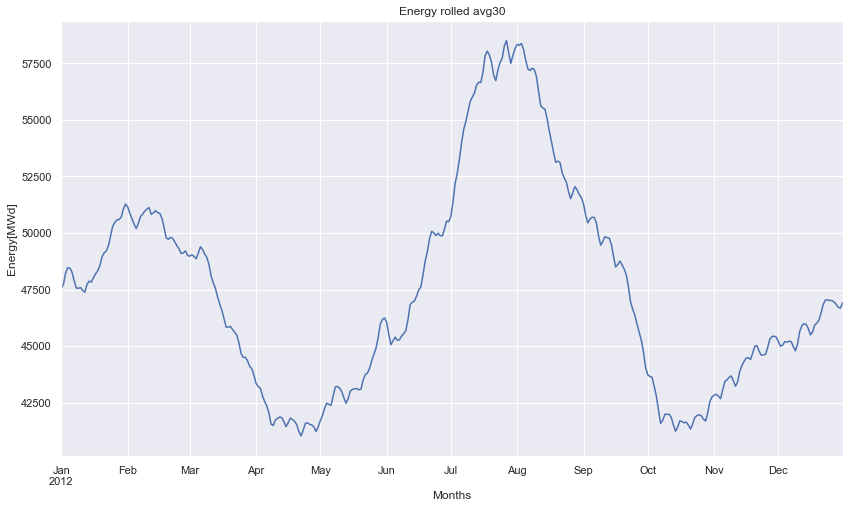

In [321]:
complete_df['Energy_MW']['2011':'2013'].rolling(30).mean()['2012':'2012'].plot(xlabel='Months', ylabel='Energy[MWd]', figsize=(14, 8), grid=True, title='Energy rolled avg30')

<AxesSubplot:title={'center':'Energy rolled avg24(1day)'}, xlabel='Days', ylabel='Energia[MWh]'>

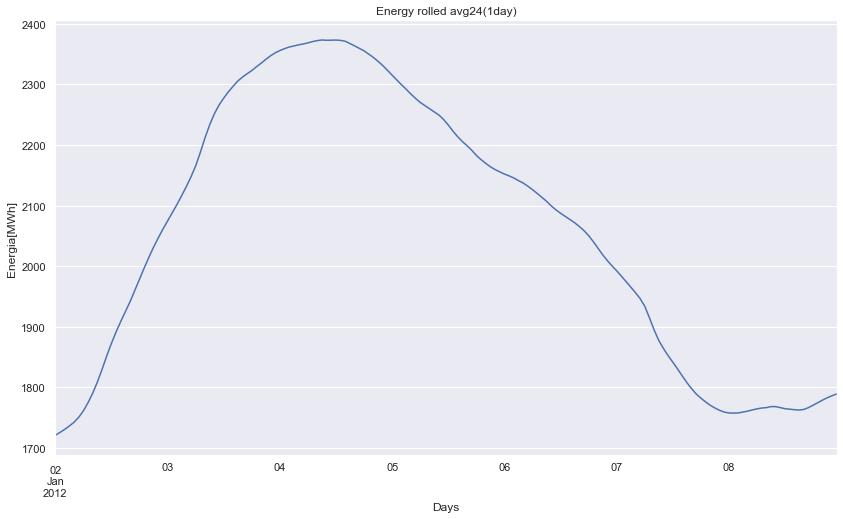

In [322]:
original_e_cons_df.set_index('Datetime')['Energy_MW']['2011':'2012'].rolling(24).mean()['2012-01-02':'2012-01-08'].plot(xlabel='Days', ylabel='Energia[MWh]', figsize=(14, 8), grid=True, title='Energy rolled avg24(1day)')

<AxesSubplot:title={'center':'Energy rolled avg6(parts of days)'}, xlabel='Days', ylabel='Energia[MWh]'>

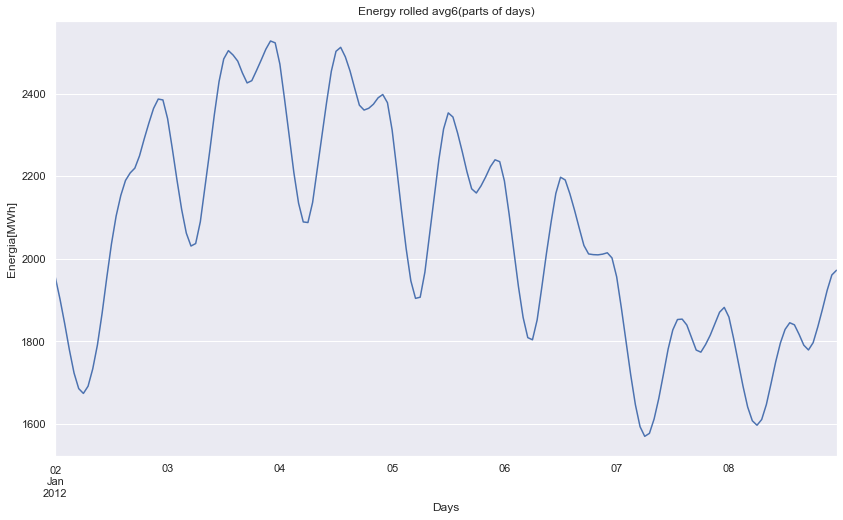

In [323]:
original_e_cons_df.set_index('Datetime')['Energy_MW']['2011':'2012'].rolling(6).mean()['2012-01-02':'2012-01-08'].plot(xlabel='Days', ylabel='Energia[MWh]', figsize=(14, 8), grid=True, title='Energy rolled avg6(parts of days)')

<AxesSubplot:title={'center':'Energy rolled avg1'}, xlabel='Days', ylabel='Energia[MWh]'>

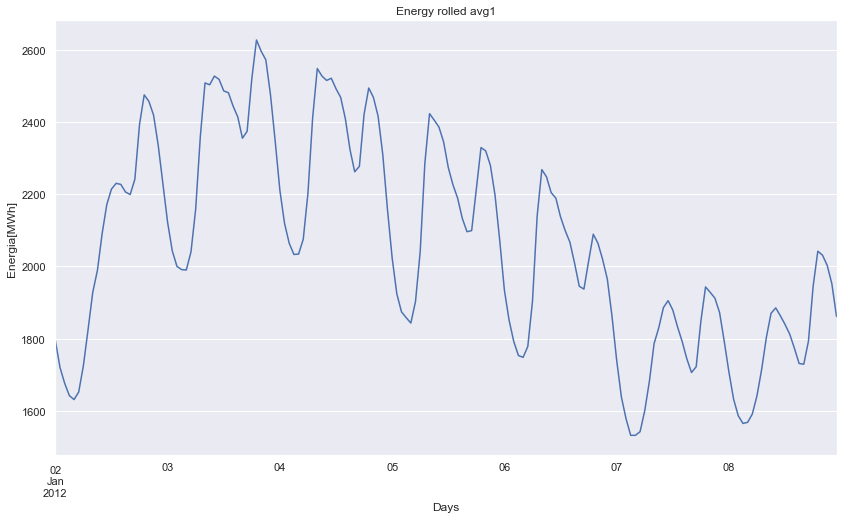

In [324]:
original_e_cons_df.set_index('Datetime')['Energy_MW']['2011':'2012'].rolling(1).mean()['2012-01-02':'2012-01-08'].plot(xlabel='Days', ylabel='Energia[MWh]', figsize=(14, 8), grid=True, title='Energy rolled avg1')

Let's check the energy in particular seasons

## 1.2 SEASONS

[Text(0, 0, '45704.3'),
 Text(0, 0, '44918'),
 Text(0, 0, '53008.4'),
 Text(0, 0, '51983')]

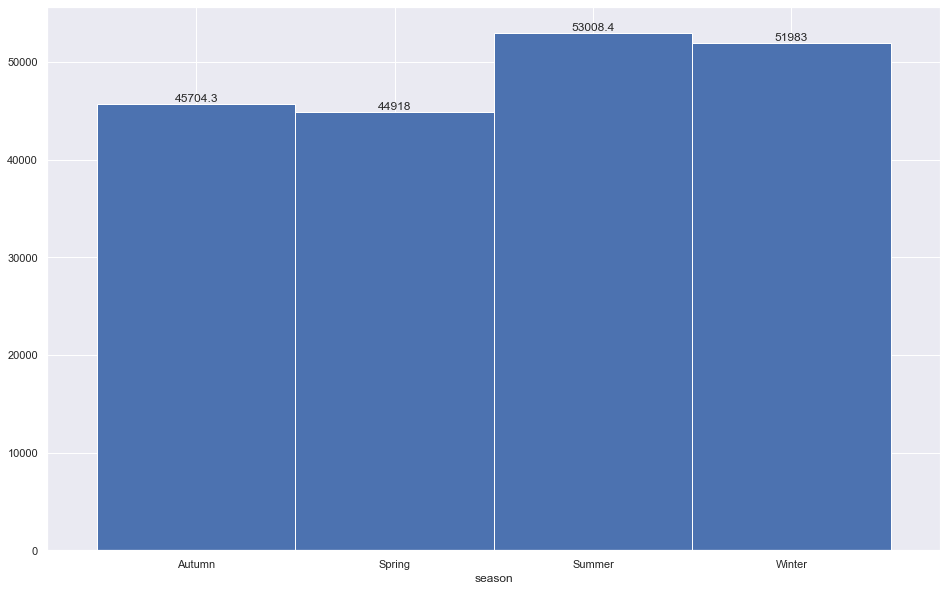

In [325]:

fig, axs = plt.subplots(1, 1, figsize=(16, 10))

complete_df.groupby('season').mean()['Energy_MW'].plot(kind='bar', width=1, edgecolor='white', rot=0, ax=axs)
axs.bar_label(axs.containers[0])

<AxesSubplot:xlabel='season', ylabel='Energy_MW'>

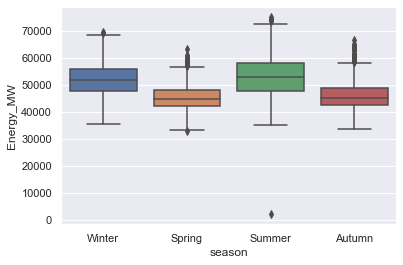

In [326]:
sns.boxplot(data=complete_df, x='season', y='Energy_MW')

We have a significant difference between summer, winter and other seasons.
**So we know that seasons matters** Let's analyze deeper, days.

## 1.3 DAYS

[Text(0, 0, '50404.5'),
 Text(0, 0, '51533'),
 Text(0, 0, '51532.1'),
 Text(0, 0, '51314.6'),
 Text(0, 0, '50016.8'),
 Text(0, 0, '44551.6'),
 Text(0, 0, '43039.7')]

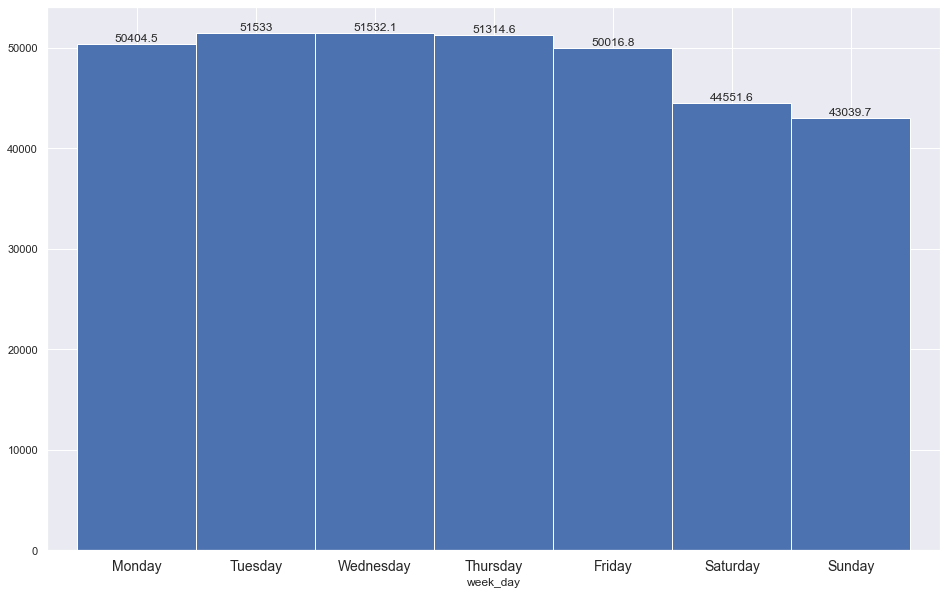

In [327]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(1, 1, figsize=(16, 10))

complete_df.groupby('week_day').mean()['Energy_MW'].plot(kind='bar', width=1, edgecolor='white', rot=0, ax=axs)
axs.set_xticklabels(days, fontsize='14')
axs.bar_label(axs.containers[0])

<AxesSubplot:xlabel='week_day', ylabel='Energy_MW'>

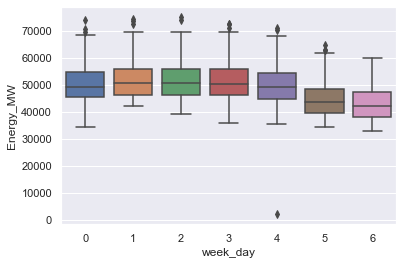

In [328]:
sns.boxplot(data=complete_df, x='week_day', y='Energy_MW')

In working days we have much higher energy consumption, let's see now energy consumption in parts of day.

### 1.4 PARTS OF DAYS

C:\Users\micha\AppData\Local\Temp\ipykernel_7232\534875543.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[7].set_xticklabels(list(part_of_day_df.index), fontsize='14')


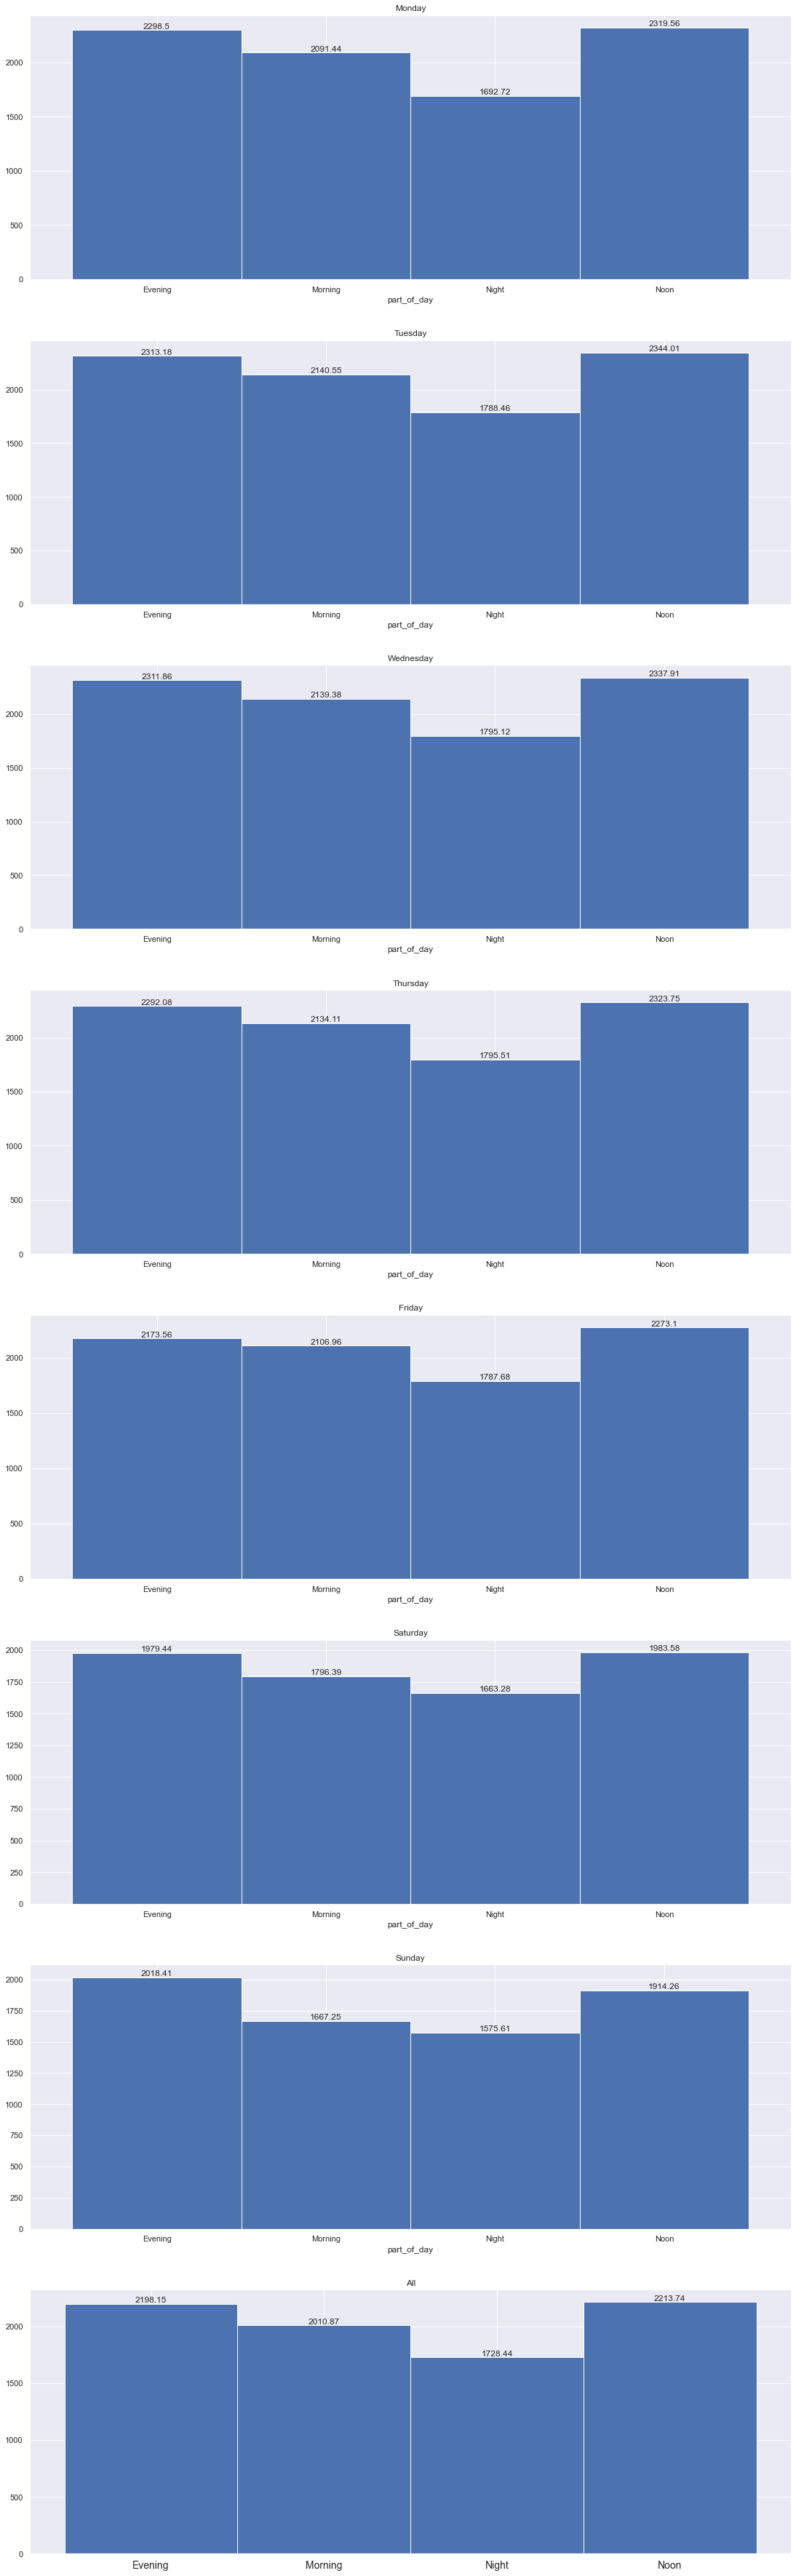

In [329]:
def part_of_day(row):
    if 0 <= row['hour'] < 6:
        val = 'Night'
    elif 6 <= row['hour'] < 12:
        val = 'Morning'
    elif 12 <= row['hour'] < 18:
        val = 'Noon'
    elif 18 <= row['hour'] <= 23:
        val = 'Evening'
    else:
        val = 0

    return val

energy_hour_df = original_e_cons_df.set_index('Datetime')

energy_hour_df['hour'] = energy_hour_df.index.hour
energy_hour_df['part_of_day'] = energy_hour_df.apply(part_of_day, axis=1)
energy_hour_df['week_day'] = energy_hour_df.index.weekday

parts_in_days_df = energy_hour_df.groupby(['week_day', 'part_of_day']).mean()['Energy_MW']
part_of_day_df =  energy_hour_df.groupby('part_of_day').mean()['Energy_MW']


fig, axs = plt.subplots(8, 1, figsize=(16, 50))
for i in range(7):
    parts_in_days_df.loc[i].plot(kind='bar', title=days[i], ax=axs[i], width=1, edgecolor='white', rot=0)
    axs[i].bar_label(axs[i].containers[0])

axs[7].bar(list(part_of_day_df.index), part_of_day_df, width=1, edgecolor='white')
axs[7].set_xticklabels(list(part_of_day_df.index), fontsize='14')
axs[7].bar_label(axs[7].containers[0])
axs[7].set_title('All')
plt.tight_layout(pad=3)


At Noon and Evening we have the highest energy consumption.

## 1.5 Trend

<AxesSubplot:xlabel='ix', ylabel='Energy_MW'>

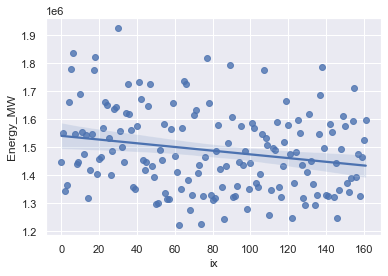

In [330]:
economic_growth_df = complete_df.groupby(pd.Grouper(freq='M')).sum()['Energy_MW'].to_frame('Energy_MW')
economic_growth_df.drop(economic_growth_df.iloc[[0, -1]].index, inplace=True, axis=0)
economic_growth_df["ix"] = range(0, len(economic_growth_df))

sns.regplot(data=economic_growth_df, x='ix', y='Energy_MW')

As we can see from regression the energy consumption is decreasing over time maybe due to more eco-friendly system. So if we want to predict our times energy consumption in next months we should use
maybe 2014-2018 years.

## 1.6 CONCLUSION

* Year does matter because when we want to predict f.e 2018 year we should choose the range from 2014 because of economic growth.
* OVERALL WE HAVE A LITTLE HIGHER ENERGY CONSUMPTION **IN WORKING DAYS, WINTER, SUMMER, EVENING, NOON**,
* In **working days** in morning we have higher energy consumption than in **weekend**
* Day doesn't matter at noon, evening and night.

I also checked population data in Dayton, but I think this feature wouldn't change that much because population changed from 712000 to 742000 over years in 2004-2018

# 2. DISTRIBUTION OF ENERGY

In [331]:
skewness = skew(complete_df['Energy_MW'])
kurt = kurtosis(complete_df['Energy_MW'])

print(f'Skewness: {skewness}, Kurtosis: {kurt}')

Skewness: 0.3113853866193292, Kurtosis: 0.21484065907261707


It means that distribution of energy has right tail, and it's not symmetric also the tails are a little thinner than in normal distribution. It means that find extreme values will be a little harder.
We can check the normal distribution with shapiro test.

In [332]:
alpha = 0.05
print("H0: Data is a normal distribution")
stat, pval = shapiro(complete_df['Energy_MW'])
if pval < alpha:
    print("H0 is rejected")
else:
    print("H0 cannot be rejected")

H0: Data is a normal distribution
H0 is rejected


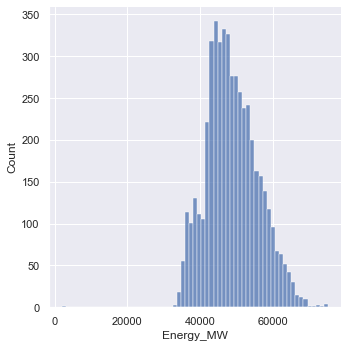

In [333]:
sns.displot(complete_df['Energy_MW'])

# 3. Feature analysis from weather api

Best way to start is to get some fast info about correlation with heatmap.

<AxesSubplot:>

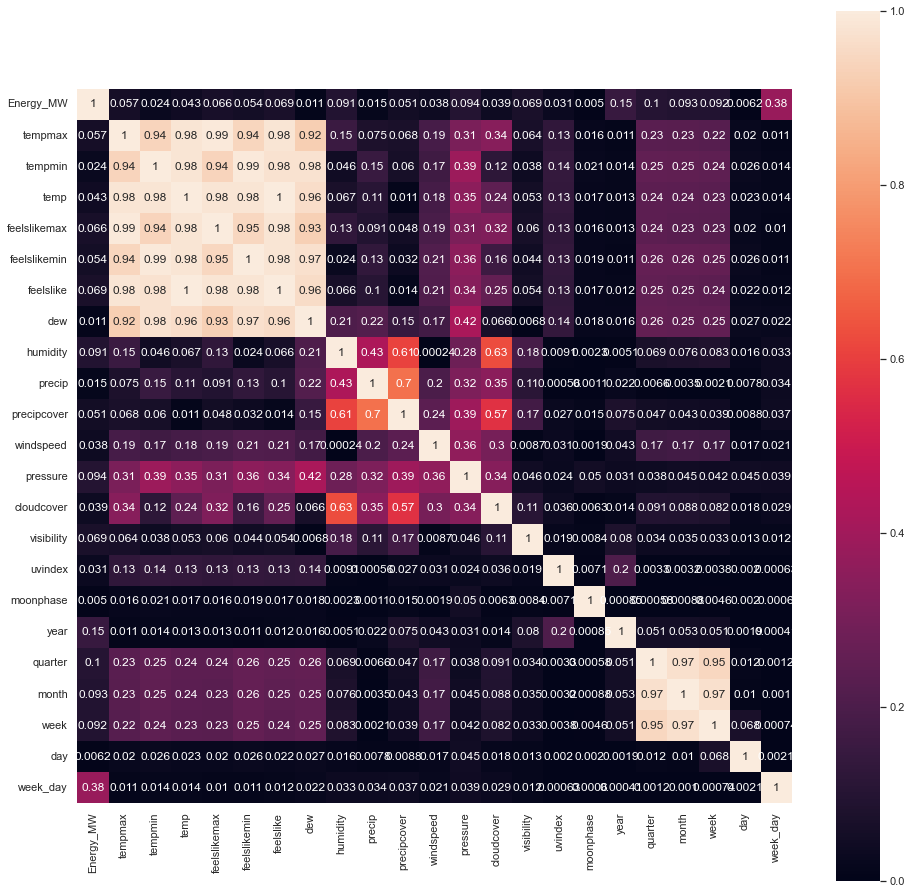

In [334]:
corrmat_complete = abs(complete_df.corr())
fig, axs = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat_complete, square=True, vmin=0, vmax=1, cmap=sns.color_palette("rocket", as_cmap=True), annot=True)


As we can see tempmin, tempmax, feeslikemax, feelslikemin, feelslike, dew are highly correlated between each other so I will choose one, **temp**
Also all features which causes moisture or rain, like humidity, precip, precipcover, cloudcover are highly correlated between each other.


c:\users\micha\desktop\projekciki\venv\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


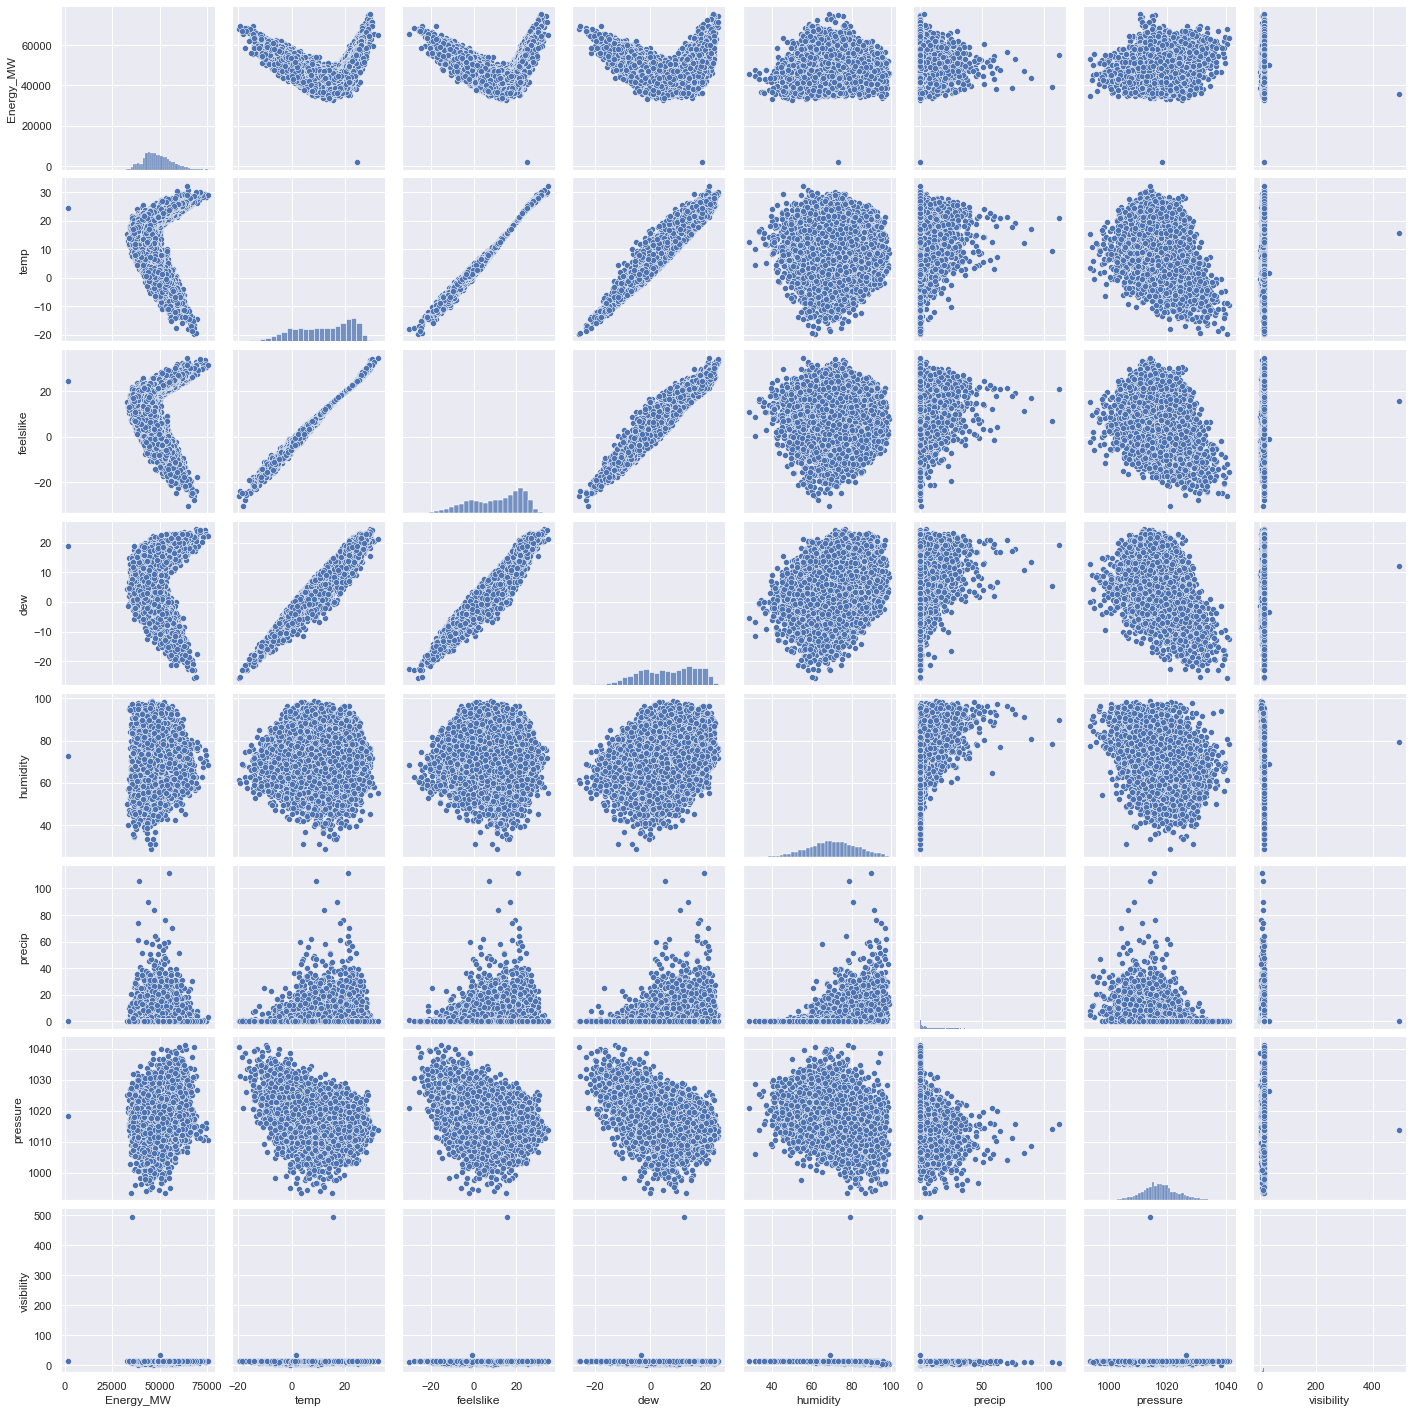

In [335]:
sns.set()
cols = ['Energy_MW', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'pressure', 'visibility']
sns.pairplot(complete_df[cols], size = 2.5)

From pairplots we can conclude that temp, feelslike and dew are strong correlated between Energy and they are also strong correlated between each other.
I decide to choose feelslike, humidity.

In [336]:
features_to_use = ['Energy_MW', 'feelslike', 'humidity', 'year', 'quarter', 'month', 'week', 'day', 'week_day', 'season']
numerical_to_use = ['Energy_MW', 'feelslike', 'humidity']
final_df = complete_df.copy()[features_to_use]

Checking trends of features from weather api

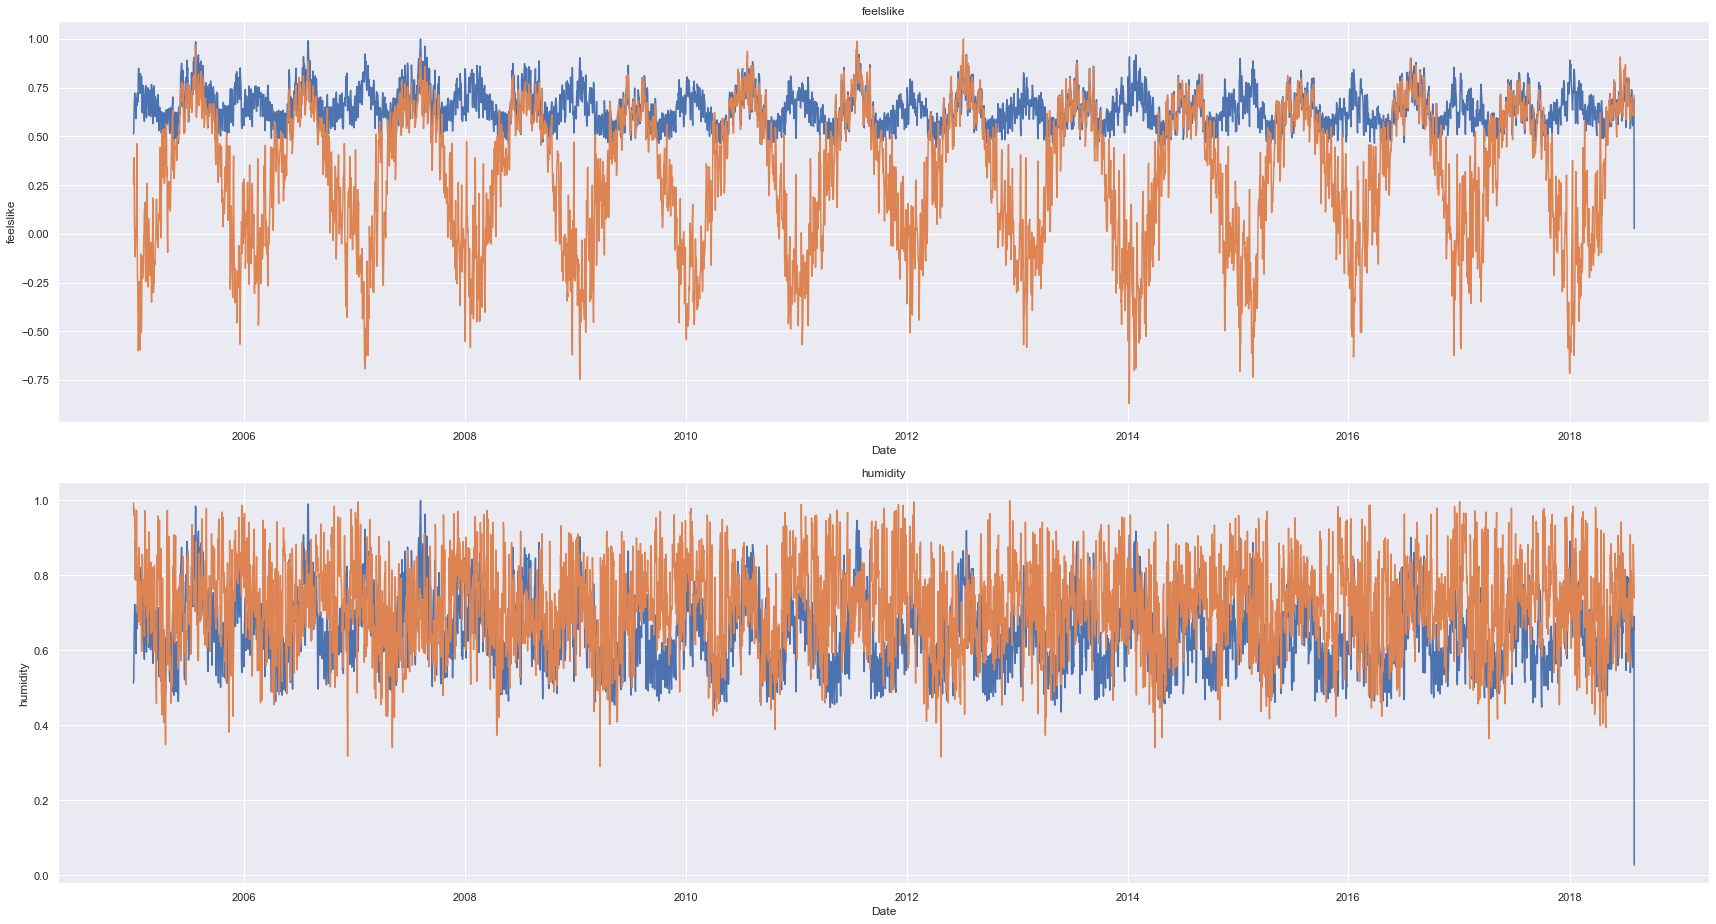

In [337]:
fig, axs = plt.subplots(2, 1, figsize=(24, 13))

for i in range(1, 3):
    axs[i-1].plot(final_df.index, final_df['Energy_MW'] / max(final_df['Energy_MW']))
    axs[i-1].plot(final_df.index, final_df[features_to_use[i]] / max(final_df[features_to_use[i]]))
    axs[i-1].set_title(features_to_use[i])
    axs[i-1].set_xlabel('Date')
    axs[i-1].set_ylabel(features_to_use[i])
plt.tight_layout()

It's strange that when temperature raises up with energy consumption, but I think it's due to air conditioning.

# 4. OHT

Implemented function to perform one hot encoding to categorical features

In [338]:
def oht_func(df, cat_features):
    encoded_features = []
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

    return encoded_features

# 5. MODELS

## 5.1 First model predict first 6 months of 2018

### 5.1.1 Encode Categorical variables

In [339]:
m1_df = final_df.copy()
cat_feat_m1 = ['year', 'quarter', 'month', 'week', 'day', 'week_day', 'season']
numerical_feat_m1 = ['humidity', 'feelslike']
target_m1 = 'Energy_MW'

In [340]:
encoded_m1_dfs = oht_func(m1_df, cat_feat_m1)
cat_encoded_feat_m1 = [j for i in encoded_m1_dfs for j in i.columns]

m1_df = pd.concat([m1_df, *encoded_m1_dfs], axis=1)

### 5.1.2 Scale Numerical Variables

In [341]:
means_m1 = []
stds_m1 = []


for i in numerical_feat_m1 + [target_m1]:
    mean = np.mean(m1_df[i])
    std = np.std(m1_df[i])
    m1_df[i] = m1_df[i].add(-mean).div(std)
    means_m1.append(mean)
    stds_m1.append(std)

### 5.1.3 Train/test split data

In [342]:
X = m1_df[cat_encoded_feat_m1 + numerical_feat_m1]
y = m1_df[target_m1]


X_train = X.loc['2014':'2017-12-31']
X_test = X.loc['2018':'2018-06-30']
y_train = y.loc['2014':'2017-12-31'].to_frame()
y_test = y.loc['2018':'2018-06-30'].to_frame()

### 5.1.4 Train model and predict

In [343]:
reg_1 = RandomForestRegressor().fit(X_train, y_train)
reg_1.fit(X_train, y_train)
m1_p_test = reg_1.predict(X_test)
y_test['predicted'] = m1_p_test

C:\Users\micha\AppData\Local\Temp\ipykernel_7232\1263501507.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_1 = RandomForestRegressor().fit(X_train, y_train)
C:\Users\micha\AppData\Local\Temp\ipykernel_7232\1263501507.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_1.fit(X_train, y_train)


In [344]:
y_test = y_test * stds_m1[2] + means_m1[2]
y_test = y_test.groupby(pd.Grouper(freq='w')).sum()

### 5.1.5 Results

In [345]:
mae_test = mean_absolute_error(y_test['Energy_MW'], y_test['predicted'])
print(f'Mean absolute error: {mae_test}')
print(f'MAE in mean of Energy: {(mae_test / y_test["Energy_MW"].mean()) * 100} % ')

Mean absolute error: 5352.077692307693
MAE in mean of Energy: 1.5634761401782438 % 


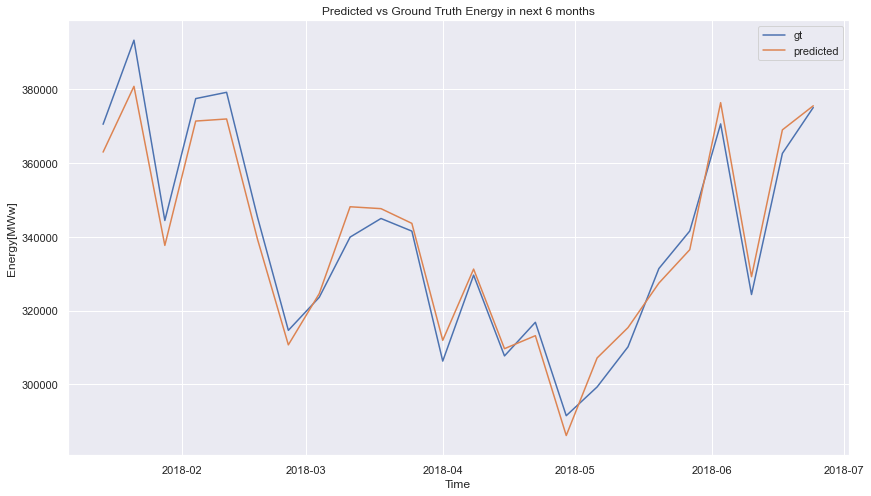

In [346]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_test.iloc[1:-1].index, y_test['Energy_MW'].iloc[1:-1])
ax.plot(y_test.iloc[1:-1].index, y_test['predicted'].iloc[1:-1])
ax.set_title('Predicted vs Ground Truth Energy in next 6 months')
ax.set_xlabel('Time')
ax.set_ylabel('Energy[MWw]')
ax.legend(['gt', 'predicted'])

## 5.2 Second model predict next days

### 5.2.1 Encode Categorical Variables

In [347]:
m2_df = energy_hour_df['2004-10-04':].copy()
cat_feat_m2 = ['hour', 'part_of_day', 'week_day']
numerical_feat_m2 = ['lag_7']
target_m2 = 'Energy_MW'

In [348]:
m2_df['lag_7'] = m2_df['Energy_MW'].shift(24*7).rolling(6).mean()

encoded_m2_dfs = oht_func(m2_df, cat_feat_m2)
cat_encoded_feat_m2 = [j for i in encoded_m2_dfs for j in i.columns]

m2_df = pd.concat([m2_df, *encoded_m2_dfs], axis=1)

### 5.2.2 Scale Categorical Variables

In [349]:
means_m2 = []
stds_m2 = []

for i in numerical_feat_m2 + [target_m2]:
    mean = np.mean(m2_df[i])
    std = np.std(m2_df[i])
    m2_df[i] = m2_df[i].add(-mean).div(std)
    means_m2.append(mean)
    stds_m2.append(std)

### 5.2.3 Train/test split data

In [350]:
X_1_train = m2_df['2016-12-7':'2016-12-13'][cat_encoded_feat_m2 + numerical_feat_m2]
X_2_train = m2_df['2017-07-07':'2017-07-13'][cat_encoded_feat_m2 + numerical_feat_m2]
y_1_train = m2_df['2016-12-7':'2016-12-13'][target_m2]
y_2_train = m2_df['2017-07-07':'2017-07-13'][target_m2]

X_1_test = m2_df['2016-12-14':'2016-12-20'][cat_encoded_feat_m2 + numerical_feat_m2]
X_2_test = m2_df['2017-07-14':'2017-07-20'][cat_encoded_feat_m2 + numerical_feat_m2]
y_1_test = m2_df['2016-12-14':'2016-12-20'][target_m2].to_frame()
y_2_test = m2_df['2017-07-14':'2017-07-20'][target_m2].to_frame()

### 5.2.4 Train model and predict

In [351]:
reg_2 = RandomForestRegressor().fit(X_1_train, y_1_train)
reg_3 = RandomForestRegressor().fit(X_2_train, y_2_train)
p_1_test = reg_2.predict(X_1_test)
p_2_test = reg_3.predict(X_2_test)

In [352]:
y_1_test['predicted'] = p_1_test
y_2_test['predicted'] = p_2_test

In [353]:
y_1_test = y_1_test * stds_m2[-1] + means_m2[-1]
y_2_test = y_2_test * stds_m2[-1] + means_m2[-1]

### 5.2.5 Results

In [354]:
mae_1_test = mean_absolute_error(y_1_test['Energy_MW'], y_1_test['predicted'])
mae_2_test = mean_absolute_error(y_2_test['Energy_MW'], y_2_test['predicted'])

print(f'Mean absolute error: {mae_1_test} for 2016-12-14 : 2016-12-21')
print(f'MAE in mean of Energy: {(mae_1_test / y_1_test["Energy_MW"].mean()) * 100} % ')
print(f'Mean absolute error: {mae_2_test} for 2017-12-14 : 2017-12-21')
print(f'MAE in mean of Energy: {(mae_2_test / y_1_test["Energy_MW"].mean()) * 100} % ')

Mean absolute error: 185.40619047619043 for 2016-12-14 : 2016-12-21
MAE in mean of Energy: 7.683808818994757 % 
Mean absolute error: 239.39690476190475 for 2017-12-14 : 2017-12-21
MAE in mean of Energy: 9.921351834720937 % 


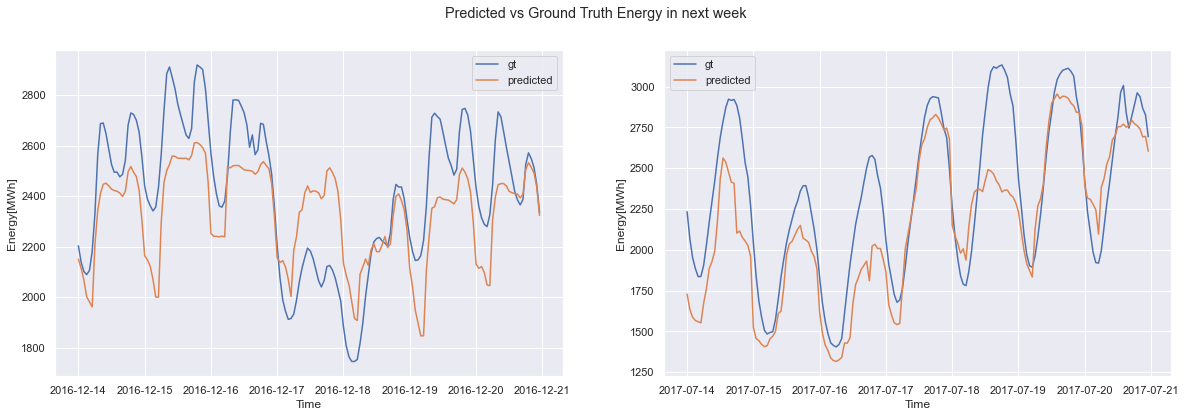

In [355]:
fig, ax = plt.subplots(1, 2,figsize=(20, 6))

fig.suptitle('Predicted vs Ground Truth Energy in next week')

ax[0].plot(y_1_test.index, y_1_test['Energy_MW'])
ax[0].plot(y_1_test.index, y_1_test['predicted'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Energy[MWh]')
ax[0].legend(['gt', 'predicted'])
ax[1].plot(y_2_test.index, y_2_test['Energy_MW'])
ax[1].plot(y_2_test.index, y_2_test['predicted'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy[MWh]')
ax[1].legend(['gt', 'predicted'])

# 6. First model application in Virginia dataset

## 6.1 Load datasets

In [356]:
virginia_df = pd.read_csv('./datasets/virginia.csv')
virginia_df['datetime'] = pd.to_datetime(virginia_df['datetime'])
virginia_df.set_index('datetime', inplace=True)

In [357]:
electrical_cons_virginia_df = pd.read_csv('./datasets/Energy_consumption_Virginia.csv')
electrical_cons_virginia_df['Datetime'] = pd.to_datetime(electrical_cons_virginia_df['Datetime'])
electrical_cons_virginia_df = electrical_cons_virginia_df.sort_values(['Datetime'])

original_elect_virginia_df = electrical_cons_virginia_df.copy()

electrical_cons_virginia_df = electrical_cons_virginia_df.set_index('Datetime').groupby(pd.Grouper(freq='d')).sum()

In [358]:
complete_virginia_df = pd.concat([electrical_cons_virginia_df, virginia_df], axis=1, join='inner')

## 6.2 Drop missing columns and not used

In [359]:
missing_columns = complete_virginia_df.isnull().sum() / len(complete_virginia_df.index) * 100

In [360]:
missing_columns = missing_columns[(missing_columns > 0)]

In [361]:
complete_virginia_df.drop(list(missing_columns.index), inplace=True, axis=1)

In [362]:
virginia_drop_col = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'dew', 'precip', 'precipcover', 'windspeed', 'pressure', 'cloudcover', 'visibility', 'uvindex', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'source', 'Unnamed: 0', 'datetimeEpoch', 'sunriseEpoch', 'sunsetEpoch']

In [363]:
complete_virginia_df.drop(virginia_drop_col, axis=1, inplace=True)

## 6.3 Add necessary features

In [364]:
complete_virginia_df['year'] = complete_virginia_df.index.year
complete_virginia_df['quarter'] = complete_virginia_df.index.quarter
complete_virginia_df['month'] = complete_virginia_df.index.month
complete_virginia_df['week'] = complete_virginia_df.index.week
complete_virginia_df['day'] = complete_virginia_df.index.day
complete_virginia_df['week_day'] = complete_virginia_df.index.weekday
complete_virginia_df['season'] = complete_virginia_df['month'].replace(seasons)

C:\Users\micha\AppData\Local\Temp\ipykernel_7232\1819308773.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  complete_virginia_df['week'] = complete_virginia_df.index.week


## 6.4 OHT cat features

In [365]:
encoded_virg_m1_dfs = oht_func(complete_virginia_df, cat_feat_m1)
cat_encoded_feat_virg_m1 = [j for i in encoded_virg_m1_dfs for j in i.columns]
complete_virginia_df = pd.concat([complete_virginia_df, *encoded_virg_m1_dfs], axis=1)

## 6.5 Scale numerical features

In [366]:
stats_virg_m1 = {}

for i in numerical_feat_m1 + [target_m1]:
    mean = np.mean(complete_virginia_df[i])
    std = np.std(complete_virginia_df[i])
    complete_virginia_df[i] = complete_virginia_df[i].add(-mean).div(std)
    stats_virg_m1[i] = [mean, std]

## 6.6 Split

In [367]:
X_virginia_m1 = complete_virginia_df[cat_encoded_feat_virg_m1 + numerical_feat_m1]['2018':'2018-06-30']
y_virginia_m1 = complete_virginia_df[target_m1]['2018':'2018-06-30'].to_frame()

## 6.7 Predict and inverse scale

In [368]:
p_virgnia_m1 = reg_1.predict(X_virginia_m1)
y_virginia_m1['predicted'] = p_virgnia_m1
y_virginia_m1 = y_virginia_m1 * stats_virg_m1['Energy_MW'][1] + stats_virg_m1['Energy_MW'][0]
y_virginia_m1 = y_virginia_m1.groupby(pd.Grouper(freq='w')).sum()

## 6.8 Results

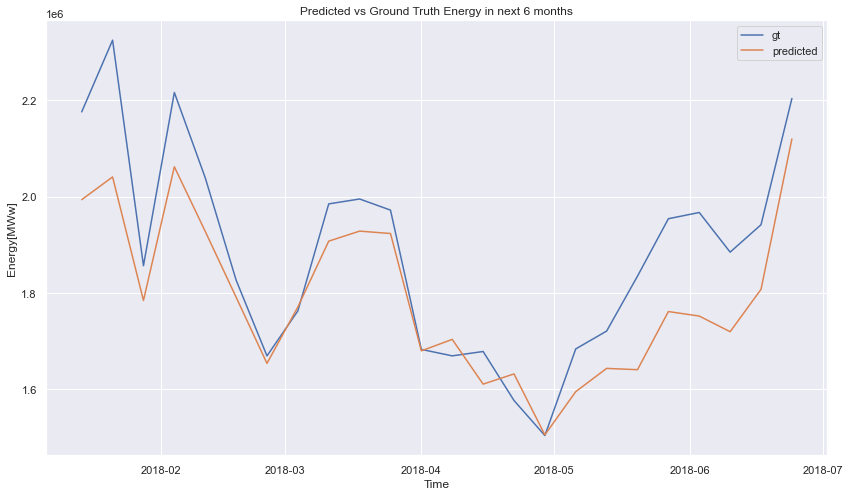

In [369]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_virginia_m1.iloc[1:-1].index, y_virginia_m1['Energy_MW'].iloc[1:-1])
ax.plot(y_virginia_m1.iloc[1:-1].index, y_virginia_m1['predicted'].iloc[1:-1])
ax.set_title('Predicted vs Ground Truth Energy in next 6 months')
ax.set_xlabel('Time')
ax.set_ylabel('Energy[MWw]')
ax.legend(['gt', 'predicted'])

In [370]:
mae_virg_m1 = mean_absolute_error(y_virginia_m1['Energy_MW'], y_virginia_m1['predicted'])
print(f'Mean absolute error: {mae_virg_m1}')
print(f'MAE in mean of Energy: {(mae_virg_m1 / y_virginia_m1["Energy_MW"].mean()) * 100} % ')

Mean absolute error: 114392.13960115415
MAE in mean of Energy: 5.95146614375785 % 


# 7 Second model application in Virginia dataset

## 7.1 Add necessary features

In [371]:
energy_hour_virginia_df = original_elect_virginia_df.set_index('Datetime')

energy_hour_virginia_df['hour'] = energy_hour_virginia_df.index.hour
energy_hour_virginia_df['part_of_day'] = energy_hour_virginia_df.apply(part_of_day, axis=1)
energy_hour_virginia_df['week_day'] = energy_hour_virginia_df.index.weekday
energy_hour_virginia_df = energy_hour_virginia_df['2005-05-02':]
energy_hour_virginia_df['lag_7'] = energy_hour_virginia_df['Energy_MW'].shift(24*7).rolling(6).mean()

## 7.2 OHT cat features

In [372]:
encoded_virg_m2_dfs = oht_func(energy_hour_virginia_df, cat_feat_m2)
cat_encoded_feat_virg_m2 = [j for i in encoded_virg_m2_dfs for j in i.columns]
energy_hour_virginia_df = pd.concat([energy_hour_virginia_df, *encoded_virg_m2_dfs], axis=1)

## 7.3 Scale numerical features

In [373]:
stats_virg_m2 = {}

for i in numerical_feat_m2 + [target_m2]:
    mean = np.mean(energy_hour_virginia_df[i])
    std = np.std(energy_hour_virginia_df[i])
    energy_hour_virginia_df[i] = energy_hour_virginia_df[i].add(-mean).div(std)
    stats_virg_m2[i] = [mean, std]

## 7.4 Split

In [374]:
X_virginia_m2 = energy_hour_virginia_df['2017-07-14':'2017-07-20'][cat_encoded_feat_virg_m2 + numerical_feat_m2]
y_virginia_m2 = energy_hour_virginia_df['2017-07-14':'2017-07-20'][target_m2].to_frame()

## 7.5 Predict

In [375]:
p_virgnia_m2 = reg_3.predict(X_virginia_m2)
y_virginia_m2['predicted'] = p_virgnia_m2
y_virginia_m2 = y_virginia_m2 * stats_virg_m2['Energy_MW'][1] + stats_virg_m2['Energy_MW'][0]

## 7.6 Results

Text(0, 0.5, 'Energy[MWh]')

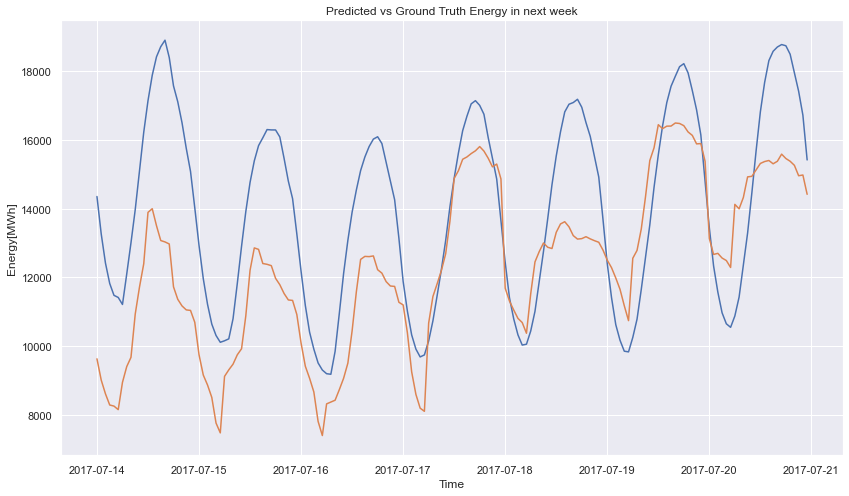

In [376]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_virginia_m2.index, y_virginia_m2['Energy_MW'])
ax.plot(y_virginia_m2.index, y_virginia_m2['predicted'])
ax.set_title('Predicted vs Ground Truth Energy in next week')
ax.set_xlabel('Time')
ax.set_ylabel('Energy[MWh]')

In [377]:
mae_virg_m2 = mean_absolute_error(y_virginia_m2['Energy_MW'], y_virginia_m2['predicted'])
print(f'Mean absolute error: {mae_virg_m2}')
print(f'MAE in mean of Energy: {(mae_virg_m2 / y_virginia_m2["Energy_MW"].mean()) * 100} % ')

Mean absolute error: 2184.823214439179
MAE in mean of Energy: 15.598664394437526 % 
